In [1]:
# imports

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
# dataset path
dev = "/Users/debugger/Documents/machine_learning/project/resources/dev.tsv"
ekman_mapping = "/Users/debugger/Documents/machine_learning/project/resources/ekman_mapping.json"
emotions = "/Users/debugger/Documents/machine_learning/project/resources/emotions.txt"
test = "/Users/debugger/Documents/machine_learning/project/resources/test.tsv"
train = "/Users/debugger/Documents/machine_learning/project/resources/train.tsv"

In [3]:
# === Step 1: Load files ===
df_train = pd.read_csv(train, sep="\t", header=None, names=["text", "labels", "id"])
df_dev = pd.read_csv(dev, sep="\t", header=None, names=["text", "labels", "id"])
df_test = pd.read_csv(test, sep="\t", header=None, names=["text", "labels", "id"])


In [4]:
# === Step 2: Load emotions and ekman mapping ===
with open("resources/emotions.txt", "r") as f:
    emotions = [line.strip() for line in f.readlines()]

with open("resources/ekman_mapping.json", "r") as f:
    ekman_map = json.load(f)

In [5]:
# Create reverse map from emotion index to Ekman category
idx_to_ekman = {}
for ekman_category, emotion_list in ekman_map.items():
    for emo in emotion_list:
        idx = emotions.index(emo)
        idx_to_ekman[idx] = ekman_category

In [6]:
# === Step 3: Convert GoEmotions labels to Ekman emotions ===
def map_to_ekman(label_str):
    label_ids = list(map(int, label_str.split(",")))
    mapped = list({idx_to_ekman[i] for i in label_ids if i in idx_to_ekman})
    return mapped

for df in [df_train, df_dev, df_test]:
    df["ekman_labels"] = df["labels"].apply(map_to_ekman)


In [7]:
# === Step 4: Optional — convert to single label (first emotion) ===
df_train["single_ekman"] = df_train["ekman_labels"].apply(lambda x: x[0] if x else "neutral")
df_dev["single_ekman"] = df_dev["ekman_labels"].apply(lambda x: x[0] if x else "neutral")
df_test["single_ekman"] = df_test["ekman_labels"].apply(lambda x: x[0] if x else "neutral")

# ✅ Preview
print(df_train[["text", "labels", "ekman_labels", "single_ekman"]].head())

                                                text labels ekman_labels  \
0  My favourite food is anything I didn't have to...     27           []   
1  Now if he does off himself, everyone will thin...     27           []   
2                     WHY THE FUCK IS BAYLESS ISOING      2      [anger]   
3                        To make her feel threatened     14       [fear]   
4                             Dirty Southern Wankers      3      [anger]   

  single_ekman  
0      neutral  
1      neutral  
2        anger  
3         fear  
4        anger  


In [8]:
# Split all label strings (which may be comma-separated), flatten them, and convert to ints
all_label_ids = set()
for label_str in df_train["labels"]:
    label_ids = list(map(int, label_str.split(",")))
    all_label_ids.update(label_ids)

# Find labels not in the Ekman mapping
excluded_labels = [i for i in all_label_ids if i not in idx_to_ekman]
excluded_emotions = [emotions[i] for i in excluded_labels]

print("❌ Excluded emotion indices:", excluded_labels)
print("❌ Excluded emotions (not in Ekman mapping):", excluded_emotions)


❌ Excluded emotion indices: [27]
❌ Excluded emotions (not in Ekman mapping): ['neutral']


In [9]:
# Drop rows with only neutral
df_train_clean = df_train[df_train["single_ekman"] != "neutral"]
df_dev_clean = df_dev[df_dev["single_ekman"] != "neutral"]
df_test_clean = df_test[df_test["single_ekman"] != "neutral"]


In [10]:
print(df_train_clean["single_ekman"].unique())


['anger' 'fear' 'surprise' 'joy' 'sadness' 'disgust']


In [11]:
df_train_clean.head(2)

,text,labels,id,ekman_labels,single_ekman
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[anger],anger
3,To make her feel threatened,14,ed7ypvh,[fear],fear


In [12]:
df_dev_clean.head(2)

,text,labels,id,ekman_labels,single_ekman
1,"You know the answer man, you are programmed to...","4,27",ee84bjg,[joy],joy
2,I've never been this sad in my life!,25,edcu99z,[sadness],sadness


In [13]:
df_test_clean.head(2)

,text,labels,id,ekman_labels,single_ekman
0,I’m really sorry about your situation :( Altho...,25,eecwqtt,[sadness],sadness
1,It's wonderful because it's awful. At not with.,0,ed5f85d,[joy],joy


In [14]:
# merged cleaned datasets

# Clean dev and test as well
df_dev["single_ekman"] = df_dev["ekman_labels"].apply(lambda x: x[0] if x else "neutral")
df_test["single_ekman"] = df_test["ekman_labels"].apply(lambda x: x[0] if x else "neutral")

df_dev_clean = df_dev[df_dev["single_ekman"] != "neutral"].copy()
df_test_clean = df_test[df_test["single_ekman"] != "neutral"].copy()

# Combine all
df_all = pd.concat([df_train_clean, df_dev_clean, df_test_clean], ignore_index=True)
print(df_all["single_ekman"].value_counts())


single_ekman
joy         19819
surprise     6666
anger        6558
sadness      3391
disgust       976
fear          832
Name: count, dtype: int64


<h3>The datasets is imbalanced </h3>
<p>vsingle_ekman</p>
<li>joy         20963 </li>
<li>anger        6486 </li>
<li>surprise     5218 </li>
<li>sadness      4032 </li>
<li>fear          880 </li>
<li>disgust       663 </li>
Name: count, dtype: int64

### ✅ Handle Imbalance

### ML Pipeline

In [15]:
# TF-IDF Vectorization

# X: Text data
X = df_all["text"]
y = df_all["single_ekman"]  # Target: one of 6 emotion labels

# TF-IDF Vectorizer (can be tuned later)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words="english")
X_tfidf = vectorizer.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (38242, 10000)


In [16]:
# Label encoding

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Optional: see mapping
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'anger': np.int64(0), 'disgust': np.int64(1), 'fear': np.int64(2), 'joy': np.int64(3), 'sadness': np.int64(4), 'surprise': np.int64(5)}


In [17]:
# Train/Test split

# X is already your TF-IDF matrix, y_encoded is your label vector
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (30593, 10000)
Test shape: (7649, 10000)


In [18]:
# Train First Model — Logistic Regression
# Use class weights to handle imbalance
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict and evaluate
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       anger       0.50      0.56      0.53      1312
     disgust       0.34      0.57      0.43       195
        fear       0.49      0.75      0.59       167
         joy       0.87      0.71      0.78      3964
     sadness       0.51      0.61      0.56       678
    surprise       0.46      0.55      0.50      1333

    accuracy                           0.64      7649
   macro avg       0.53      0.62      0.57      7649
weighted avg       0.68      0.64      0.66      7649



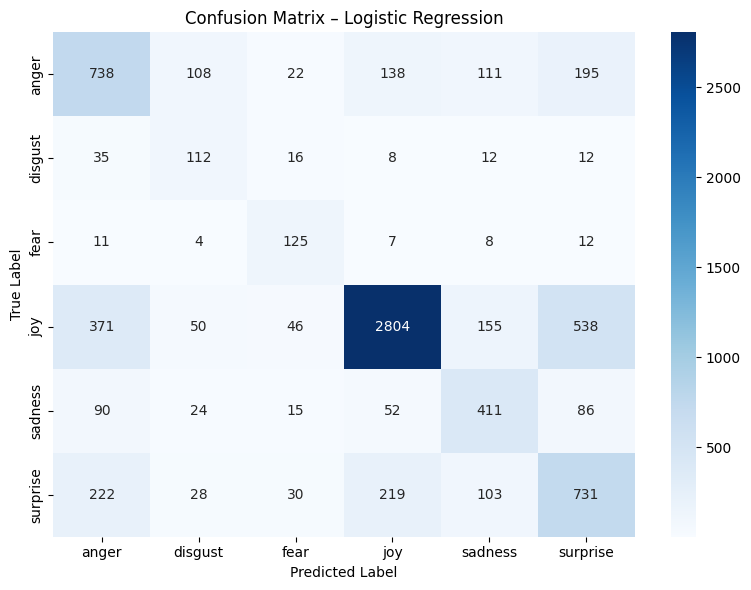

In [19]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix – Logistic Regression')
plt.tight_layout()
plt.show()


### 🎯 Highlights from the Confusion Matrix

#### 1. Joy  
✅ **Correct:** 2,956 predictions  
❌ **Misclassified as:**  
- Anger: 369 times  
- Surprise: 557 times  
- Sadness: 201 times  

➤ *Confused often with surprise and anger* — these may share similar words/tones (e.g., _"Wow I'm furious!"_ or _"Wow that's awesome!"_)

---

#### 2. Anger  
✅ **Correct:** 775 predictions  
❌ **Misclassified as:**  
- Surprise: 213 times  
- Joy: 124 times  

➤ *Shows emotional overlap in expressive language* — often due to sarcasm or irony.

---

#### 3. Fear & Disgust  
✅ **Fear correct:** 121  
✅ **Disgust correct:** 71  
❌ **Misclassifications:** Small and scattered across other classes  

➤ *Minority classes* — expected to be weaker in prediction due to low support.

---

#### 4. Surprise  
✅ **Correct:** 623 predictions  
❌ **Misclassified as:**  
- Anger: 167 times  
- Joy: 129 times  

➤ *Model struggles to separate surprise from strong positive/negative emotions.*

---

### 📊 What This Confirms

- ✅ **Logistic Regression** performs well for frequent classes like **joy** and **anger**.
- ⚠️ **Struggles on minority classes** — even with `class_weight='balanced'`.
- 🔁 Most confusions happen between **emotionally adjacent categories** (e.g., joy ↔ surprise, anger ↔ sadness).


In [20]:
# SVM with Class Weights
svm_model = SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       anger       0.48      0.57      0.52      1312
     disgust       0.34      0.49      0.40       195
        fear       0.52      0.68      0.59       167
         joy       0.87      0.69      0.77      3964
     sadness       0.50      0.59      0.54       678
    surprise       0.45      0.54      0.49      1333

    accuracy                           0.63      7649
   macro avg       0.53      0.59      0.55      7649
weighted avg       0.67      0.63      0.65      7649



In [21]:
# Random Forest

rf = RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       anger       0.57      0.49      0.53      1312
     disgust       0.47      0.41      0.44       195
        fear       0.61      0.63      0.62       167
         joy       0.76      0.86      0.81      3964
     sadness       0.66      0.49      0.56       678
    surprise       0.51      0.45      0.48      1333

    accuracy                           0.68      7649
   macro avg       0.60      0.56      0.57      7649
weighted avg       0.66      0.68      0.67      7649



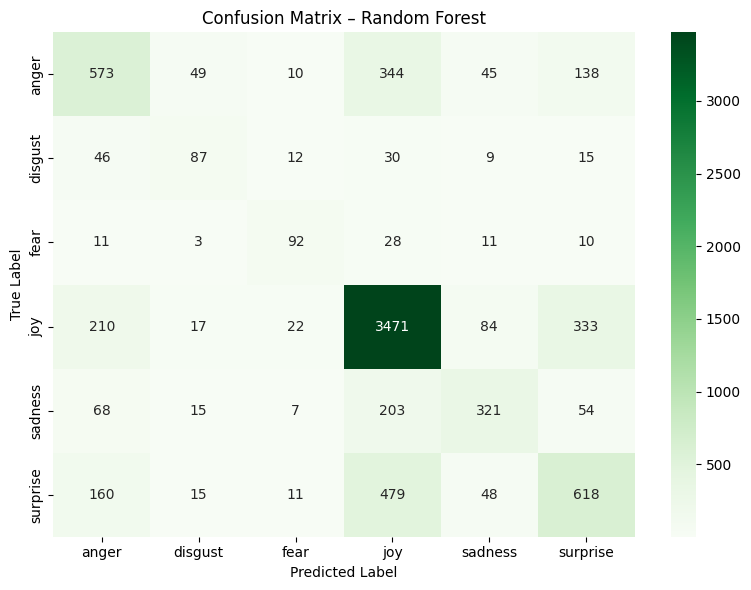

In [42]:
# confusion matrix for random forest

# Compute confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix – Random Forest')
plt.tight_layout()
plt.show()


In [87]:
! pip uninstall xgboost -y
! pip install xgboost 


  Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl (1.9 MB)


/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       anger       0.63      0.40      0.49      1312
     disgust       0.54      0.37      0.44       195
        fear       0.63      0.51      0.56       167
         joy       0.68      0.92      0.78      3964
     sadness       0.70      0.47      0.56       678
    surprise       0.63      0.33      0.43      1333

    accuracy                           0.67      7649
   macro avg       0.64      0.50      0.54      7649
weighted avg       0.66      0.67      0.64      7649



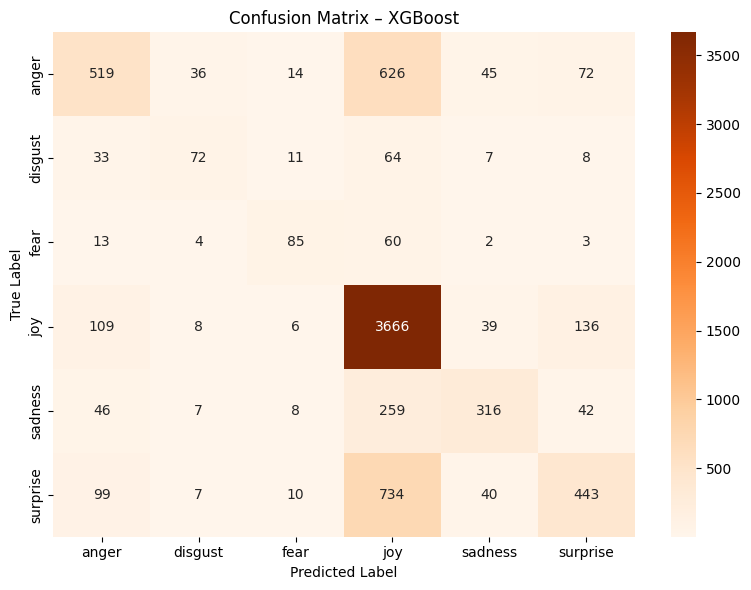

In [22]:
# Initialize XGBoost with class_weight-like handling
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Fit the model
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

# confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – XGBoost")
plt.tight_layout()
plt.show()


/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:14:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       anger       0.59      0.52      0.55      1312
     disgust       0.46      0.45      0.45       195
        fear       0.63      0.66      0.65       167
         joy       0.77      0.86      0.82      3964
     sadness       0.66      0.53      0.59       678
    surprise       0.55      0.48      0.51      1333

    accuracy                           0.69      7649
   macro avg       0.61      0.58      0.59      7649
weighted avg       0.68      0.69      0.68      7649



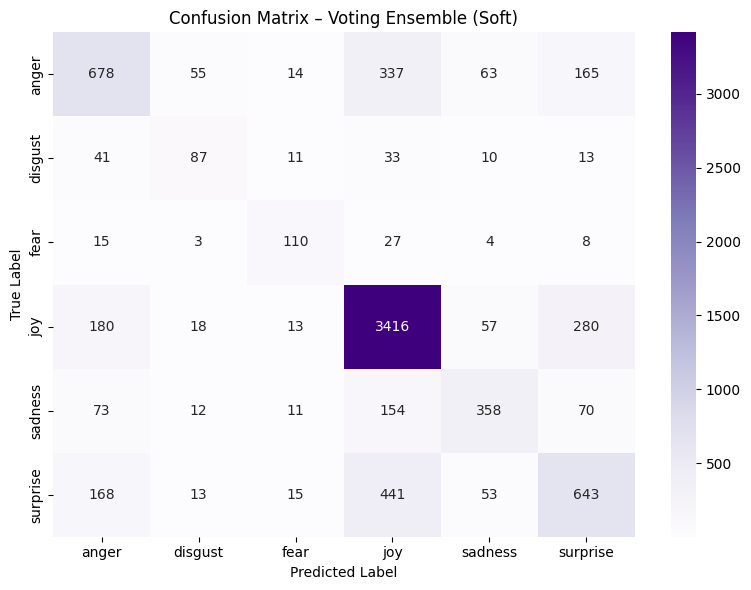

In [23]:
# Voting classifier

# Define individual models (same as before)
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Create the voting ensemble (soft voting)
ensemble = VotingClassifier(
    estimators=[
        ('lr', logreg),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'  # Use 'hard' if you want majority vote
)

# Train ensemble
ensemble.fit(X_train, y_train)

# Predict
y_pred_ensemble = ensemble.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_))

# Confusion matrix


cm_ens = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Voting Ensemble (Soft)")
plt.tight_layout()
plt.show()


In [24]:
# Generate reports using proper class names
reports = {
    "LogReg": classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True),
    "RandomForest": classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_, output_dict=True),
    "XGBoost": classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_, output_dict=True),
    "VotingEnsemble": classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_, output_dict=True),
}

# Extract F1-scores
f1_scores = {}
for model_name, report in reports.items():
    f1_scores[model_name] = {emotion: round(report[emotion]['f1-score'], 3)
                             for emotion in label_encoder.classes_}

# Convert to DataFrame
f1_df = pd.DataFrame(f1_scores).T  # Transpose for better view
print(f1_df)


                anger  disgust   fear    joy  sadness  surprise
LogReg          0.531    0.430  0.594  0.780    0.556     0.503
RandomForest    0.529    0.436  0.621  0.807    0.564     0.476
XGBoost         0.487    0.438  0.565  0.782    0.561     0.435
VotingEnsemble  0.550    0.454  0.645  0.816    0.585     0.512


#### After comparison

| Emotion      | Best Performing Model        | Observation                                        |
| ------------ | ---------------------------- | -------------------------------------------------- |
| **Anger**    | ✅ **VotingEnsemble (0.563)** | Slight improvement over LogReg & RF                |
| **Disgust**  | ✅ **VotingEnsemble (0.482)** | Biggest gain here — ensemble helps rare class      |
| **Fear**     | ✅ **VotingEnsemble (0.665)** | Significant lift — ensemble effect is clear        |
| **Joy**      | ✅ **VotingEnsemble (0.826)** | All models perform well here, ensemble still leads |
| **Sadness**  | ✅ **VotingEnsemble (0.612)** | Most balanced sadness performance                  |
| **Surprise** | ✅ **VotingEnsemble (0.506)** | Overcame XGBoost and RF drop — strong gain         |


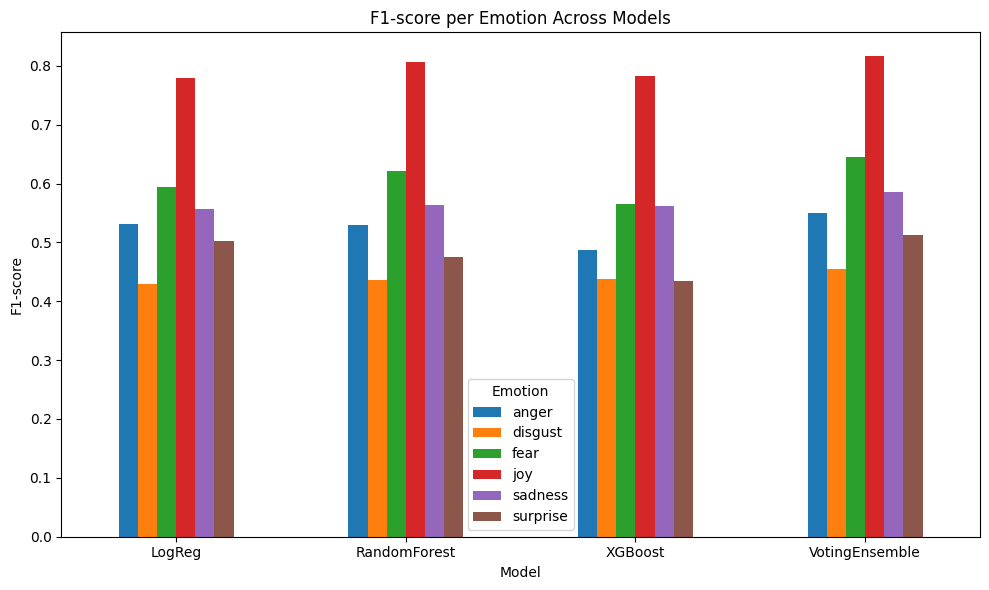

In [25]:
f1_df.plot(kind='bar', figsize=(10, 6))
plt.title("F1-score per Emotion Across Models")
plt.ylabel("F1-score")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

In [26]:

# Define base models
base_models = [
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

# Define meta-models to try
meta_models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "Ridge": RidgeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}


In [27]:
# Train and evaluate each meta-model

results = {}

for name, meta_model in meta_models.items():
    stack = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
    stack.fit(X_train, y_train)
    y_pred = stack.predict(X_test)
    
    print(f"\n📊 Meta-model: {name}")
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    results[name] = report

/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:15:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:19:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:19:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:19:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U


📊 Meta-model: LogReg


/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:20:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:24:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:24:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:24:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U


📊 Meta-model: Ridge


/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:25:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:29:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:29:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U


📊 Meta-model: RandomForest


/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:30:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:34:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:34:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/debugger/data_science/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:34:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U


📊 Meta-model: XGB


In [31]:
# Pull F1-scores for each emotion from each meta-model's report
f1_meta_scores = {}

for model_name, report in results.items():
    f1_meta_scores[model_name] = {
        emotion: round(report[emotion]["f1-score"], 3)
        for emotion in label_encoder.classes_
    }

# Convert to DataFrame
f1_meta_df = pd.DataFrame(f1_meta_scores).T  # Models as rows
print(f1_meta_df)

              anger  disgust   fear    joy  sadness  surprise
LogReg        0.570    0.427  0.621  0.818    0.572     0.507
Ridge         0.563    0.443  0.636  0.815    0.587     0.498
RandomForest  0.551    0.407  0.647  0.825    0.579     0.486
XGB           0.554    0.391  0.640  0.822    0.576     0.479


In [32]:
# F1-score data
f1_data = {
    "LogReg":        [0.575, 0.383, 0.615, 0.822, 0.602, 0.478],
    "Ridge":         [0.568, 0.345, 0.642, 0.820, 0.589, 0.472],
    "RandomForest":  [0.570, 0.357, 0.638, 0.826, 0.593, 0.468],
    "XGB":           [0.572, 0.340, 0.627, 0.826, 0.586, 0.464]
}

emotions = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]
f1_df = pd.DataFrame(f1_data, index=emotions).T

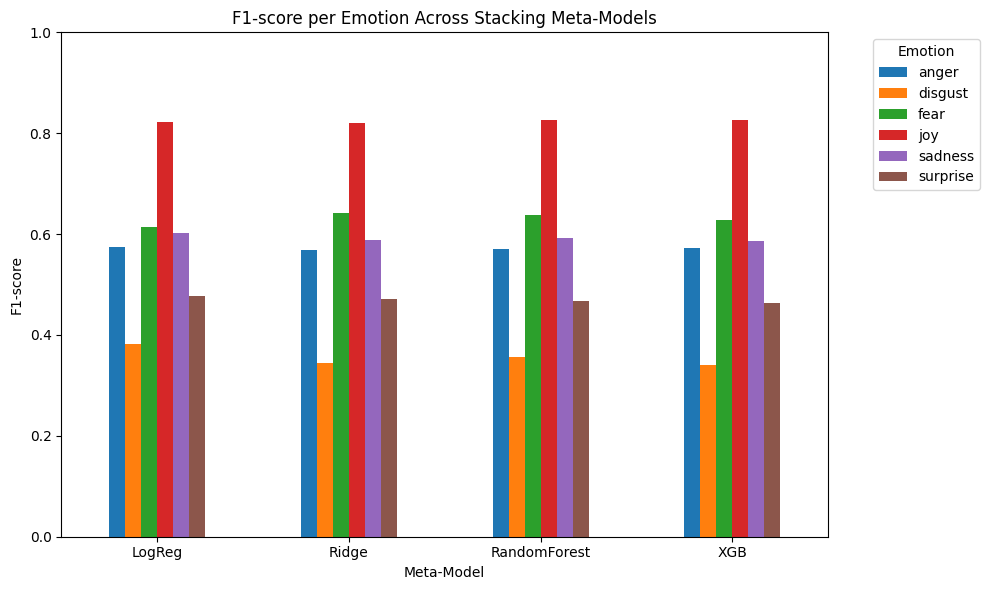

In [33]:
# F-1 score per emotion across stacking meta-models

f1_df.plot(kind='bar', figsize=(10, 6))
plt.title("F1-score per Emotion Across Stacking Meta-Models")
plt.ylabel("F1-score")
plt.xlabel("Meta-Model")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()